In [6]:
from pathlib import Path

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from src.crimp import crimp
from src.baselines import rank_degree, rank_betweenness, rank_pagerank, rank_cycle_ratio_base
from src.datasets import DATASETS, load_edgelist_txt

In [2]:
# Load datasets and compute basic network statistics
graphs = {}
rows = []

for name, rel_path in DATASETS.items():
    path = Path(rel_path)
    G = load_edgelist_txt(path, directed=False)
    G = nx.Graph(G)  # ensure undirected
    G.remove_edges_from(nx.selfloop_edges(G))

    graphs[name] = G

    n = G.number_of_nodes()
    m = G.number_of_edges()
    avg_degree = (2 * m / n) if n > 0 else 0.0

    rows.append({
        "dataset": name,
        "nodes": n,
        "edges": m,
        "avg_degree": avg_degree,
        "is_connected": nx.is_connected(G) if n > 0 else False,
        "num_components": nx.number_connected_components(G) if n > 0 else 0,
    })

summary_df = pd.DataFrame(rows).sort_values("nodes", ascending=False).reset_index(drop=True)
summary_df

,dataset,nodes,edges,avg_degree,is_connected,num_components
0,Yeast,2375,11693,9.846737,True,1
1,Email,1133,5451,9.622242,True,1
2,NS_GC,379,914,4.823219,True,1
3,USAir,332,2126,12.807229,True,1
4,Celegans,297,2148,14.464646,True,1
5,Jazz,198,2742,27.696970,True,1


In [3]:
def rank_crimp(G):
    return crimp(G).r_imp

rankers = {
    "CRimp": rank_crimp,
    "CycleRatioBase": rank_cycle_ratio_base,
    "Degree": rank_degree,
    "Betweenness": rank_betweenness,
    "PageRank": rank_pagerank,
}

def giant_component_fraction(G):
    n = G.number_of_nodes()
    if n == 0:
        return 0.0
    gcc = max((len(c) for c in nx.connected_components(G)), default=0)
    return gcc / n

def targeted_removal_curve(G, ordering):
    H = G.copy()
    n0 = H.number_of_nodes()

    removed = 0
    rows = [{"removed_frac": 0.0, "gcc_frac": giant_component_fraction(H)}]

    for node in ordering:
        if H.has_node(node):
            H.remove_node(node)
            removed += 1
            rows.append({
                "removed_frac": removed / n0,
                "gcc_frac": giant_component_fraction(H)
            })

    return pd.DataFrame(rows)

def auc(x, y):
    return float(np.trapezoid(y, x))

def gcc_at_points(x, y, points=(0.1, 0.2, 0.3, 0.5)):
    out = {}
    for p in points:
        out[f"gcc@{p}"] = float(np.interp(p, x, y))
    return out

def p_star(x, y, thresh=0.1):
    y = np.array(y)
    x = np.array(x)
    idx = np.where(y <= thresh)[0]
    return float(x[idx[0]]) if len(idx) else 1.0

In [4]:
OUT_DIR = Path("../results")
OUT_DIR.mkdir(parents=True, exist_ok=True)

all_metrics = []

for ds_name, G in graphs.items():
    curves = []
    for method, fn in rankers.items():
        scores = fn(G)
        ordering = [n for n, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)]
        df_curve = targeted_removal_curve(G, ordering)
        df_curve["dataset"] = ds_name
        df_curve["method"] = method
        curves.append(df_curve)

    perc_df = pd.concat(curves, ignore_index=True)

    # metrics table for this dataset
    for method in perc_df["method"].unique():
        tmp = perc_df[(perc_df["dataset"] == ds_name) & (perc_df["method"] == method)].sort_values("removed_frac")
        x = tmp["removed_frac"].values
        y = tmp["gcc_frac"].values

        row = {"dataset": ds_name, "method": method}
        row["auc"] = auc(x, y)
        row["p_star_gcc_lt_0.1"] = p_star(x, y, thresh=0.1)
        row.update(gcc_at_points(x, y, points=(0.1, 0.2, 0.3, 0.5)))
        all_metrics.append(row)

metrics_df = pd.DataFrame(all_metrics).sort_values(["dataset", "auc"]).reset_index(drop=True)
metrics_df.to_csv(OUT_DIR / "percolation_metrics_real_datasets.csv", index=False)

metrics_df

,dataset,method,auc,p_star_gcc_lt_0.1,gcc@0.1,gcc@0.2,gcc@0.3,gcc@0.5
0,Celegans,PageRank,0.451588,0.626263,0.928919,0.907407,0.870130,0.350172
1,Celegans,CRimp,0.453162,0.521886,0.932660,0.903198,0.855700,0.407378
2,Celegans,Degree,0.459139,0.636364,0.928919,0.915825,0.884560,0.383843
3,Celegans,CycleRatioBase,0.492366,0.720539,0.936401,0.897302,0.874940,0.346771
4,Celegans,Betweenness,0.505905,0.794613,0.936401,0.920033,0.884560,0.424247
5,Email,PageRank,0.292161,0.382171,0.914386,0.804722,0.614550,0.010591
6,Email,CRimp,0.294622,0.412180,0.895753,0.783098,0.586433,0.014122
7,Email,CycleRatioBase,0.301151,0.370697,0.928116,0.815755,0.618081,0.014122
8,Email,Degree,0.310754,0.399823,0.928410,0.831641,0.630184,0.015887
9,Email,Betweenness,0.324180,0.432480,0.907816,0.799206,0.621611,0.033539


In [9]:
best_df = (
    metrics_df.sort_values(["dataset", "auc"])
    .groupby("dataset", as_index=False)
    .head(1)
    .reset_index(drop=True)
)
best_df


,dataset,method,auc,p_star_gcc_lt_0.1,gcc@0.1,gcc@0.2,gcc@0.3,gcc@0.5
0,Celegans,PageRank,0.451588,0.626263,0.928919,0.907407,0.870130,0.350172
1,Email,PageRank,0.292161,0.382171,0.914386,0.804722,0.614550,0.010591
2,Jazz,Betweenness,0.600194,0.782828,0.971941,0.962121,0.935064,0.858586
3,NS_GC,CycleRatioBase,0.073314,0.084433,0.076224,0.046174,0.022616,0.026385
4,USAir,PageRank,0.137729,0.180723,0.588997,0.089599,0.064544,0.024096
5,Yeast,PageRank,0.155479,0.233263,0.714620,0.345789,0.031278,0.005895


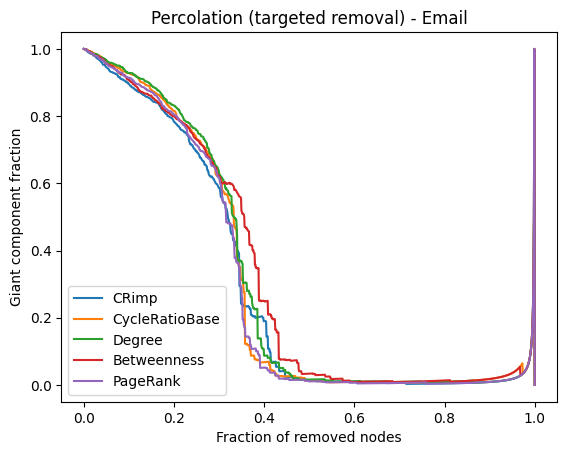

In [7]:
ds_name = "Email"
G = graphs[ds_name]

curves = []
for method, fn in rankers.items():
    scores = fn(G)
    ordering = [n for n, _ in sorted(scores.items(), key=lambda x: x[1], reverse=True)]
    df_curve = targeted_removal_curve(G, ordering)
    df_curve["method"] = method
    curves.append(df_curve)

perc_one = pd.concat(curves, ignore_index=True)

for method in perc_one["method"].unique():
    tmp = perc_one[perc_one["method"] == method]
    plt.plot(tmp["removed_frac"], tmp["gcc_frac"], label=method)

plt.title(f"Percolation (targeted removal) - {ds_name}")
plt.xlabel("Fraction of removed nodes")
plt.ylabel("Giant component fraction")
plt.legend()
plt.show()